In [9]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


# 绘图

In [2]:
from datetime import date
today_for_api  = str(date.today())
import pandas as pd
import numpy as np
#######图形模版
import seaborn as sns
cm=sns.color_palette("Spectral", as_cmap=True)
#cm = sns.light_palette("Spectral", as_cmap=True)
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
font = ['Songti SC']
parameters = {'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          "font.family" : "sans-serif",
          "font.sans-serif":font,
          'font.size':15,
          "axes.unicode_minus":False}
plt.rcParams.update(parameters)

/var/folders/bg/h2_d2l2939102wvpkt70y0_00000gn/T/ipykernel_8416/460664487.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark")


In [3]:
#! conda install seaborn

# 读数据 :wind 宏观+指数+alpha

In [114]:
import pickle
f2 = open('temp.pkl', 'rb')  
macro_data = pickle.load(f2)  
macro_zscore = pickle.load(f2)  
index_orig = pickle.load(f2)  
index_transformer = pickle.load(f2)  
df_fund = pickle.load(f2)  
df_fund.index=df_fund.index.to_period("M")
f2.close() 

df_ret_ratio=index_orig

# 基于月度数据夏普估计：夏普方法2

#Whitelaw（1997）


index_sharpe=index_orig

df_ret_ratio_mean_monthly=index_sharpe.resample("M").sum()
df_ret_ratio_std_monthly=np.sqrt((df_ret_ratio**2).resample("M").sum())
df_sharpe =df_ret_ratio_mean_monthly/df_ret_ratio_std_monthly

df_sharpe.mean()




MSCI中国A股(人民币)          0.155037
MSCI中国A股在岸低波(人民币)      0.205786
MSCI中国A股在岸公司质量(人民币)    0.225771
MSCI中国A股在岸价值(人民币)      0.124020
MSCI中国A股在岸成长(人民币)      0.162680
MSCI中国A股在岸中小盘(人民币)     0.202491
MSCI中国A股在岸动能(人民币)      0.156768
dtype: float64

# 模型准备

In [ ]:
#import sys

In [ ]:
#import scipy 


In [ ]:
#sys.path.insert(0, '/Users/xinyuexu/recombinator/')

In [7]:
import arviz as az
import pymc as pm
import aesara.tensor as at
#import recombinator

from recombinator.block_bootstrap import circular_block_bootstrap


In [8]:
1+1
print(f"Running on ArviZ v{az.__version__}")

Running on ArviZ v0.14.0


In [9]:

y_star_cb   = circular_block_bootstrap(df_sharpe, 
                               block_length=36, 
                               replications=500, 
                               replace=True)




IR_estimate_from_bootstrap = np.zeros((500,np.shape(y_star_cb)[2]))
for b in range(500):
       IR_estimate_from_bootstrap[b,:] =  np.mean(y_star_cb[b,:,:],axis=0)
IR_mean=IR_estimate_from_bootstrap.mean(axis=0)

IR_sample_std=IR_estimate_from_bootstrap.std(axis=0)

model_begin_date="2012-09-01"

index_transformer_month= index_transformer.resample("M").sum()



df_data = pd.DataFrame(columns = ["Period"]).set_index("Period")
date_model =pd.date_range(start=model_begin_date,end="2022-09-01",freq="M").to_period("M")
df_data.index=date_model
df_data["Test_"] = "True"



df_macro_filter = pd.concat([df_data,macro_zscore.shift(3)],axis=1).query('Test_=="True"')
df_macro_filter_predict = pd.concat([df_data,macro_zscore],axis=1).query('Test_=="True"')

df_Factor_filter=pd.concat([df_data,index_transformer_month],axis=1).query('Test_=="True"')
data_alpha_filter =pd.concat([df_data,df_fund],axis=1).query('Test_=="True"')
data_alpha_filter= data_alpha_filter.dropna(axis=1)

data_total =pd.concat([df_Factor_filter.drop("Test_",axis=1),data_alpha_filter.drop("Test_",axis=1)],axis=1).T


Df_macro = df_macro_filter.drop("Test_",axis=1).T
Df_macro_predict = df_macro_filter_predict.drop("Test_",axis=1).T


Df_Factor=df_Factor_filter.drop("Test_",axis=1).T
Df_alpha=data_alpha_filter.drop("Test_",axis=1).T
prior_mu = np.array([x for x in IR_mean])
prior_std = np.array([x for x in IR_sample_std])






In [11]:
RANDOM_SEED = 8924

In [116]:
#Df_macro_predict.loc["ntis"].plot()

In [13]:
Df_model_example = Df_macro.head(1)

macro_dim =Df_model_example.shape[0]

fund_dim= Df_Factor.shape[0]

model_dim =data_total.shape[0]

model_dim_T=date_model.shape[0]
alpha_mean__prior =2
alpha_std__prior =0.17
LKJ_eta__prior =3
LKJ_st__prior =1.0
LKJ_st_prior =1.0
T_len=model_dim_T
__Df_alpha_model=Df_alpha
alpha_len = __Df_alpha_model.shape[0]

In [14]:
fund_dim= Df_Factor.shape[0]

model_dim =data_total.shape[0]

model_dim_T=date_model.shape[0]

In [15]:
data_total.columns

PeriodIndex(['2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02',
             '2013-03', '2013-04', '2013-05', '2013-06',
             ...
             '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04',
             '2022-05', '2022-06', '2022-07', '2022-08'],
            dtype='period[M]', length=120)

# 跑模型（13个模型）:模型的结果已存储

In [9]:

for i in Df_macro.index:
    model_name = "model_total_"+i
    result_name = "trace_alpha_total_"+i
    Df_model_example = Df_macro.loc[[i]]
    
    macro_dim =Df_model_example.shape[0]
    coords_test = {"Fund": Df_Factor.index.values, "date":data_total.columns.to_timestamp().astype("int"),"macro":Df_model_example.index.values,"Alpha":__Df_alpha_model.index.values}
    s="""with pm.Model(coords=coords_test) as {}:
        sharpe_ratio= pm.Normal("μ", prior_mu.T, prior_std, dims=("Fund"))
        sharpe_ratio=at.reshape(sharpe_ratio,(fund_dim,1))
        beta = pm.Normal("beta", mu=0, sigma=20,shape=(fund_dim,macro_dim),dims=("Fund","macro"))
        data_macro = pm.Data("data", Df_model_example.values.astype(float),mutable=True,dims=("macro","date"))
        sharpe_ratio_t = pm.Deterministic("SR_t",at.tile(sharpe_ratio,(1,model_dim_T)) + at.dot(beta,data_macro),dims=("Fund","date"))
        #sd_dist=pm.Exponential("std",1.0,shape=6,dims=("Fund"))
        sd_dist=pm.Exponential("std",1.0,shape=fund_dim,dims=("Fund"))
        sd_dist= at.reshape(sd_dist,(fund_dim,1))
        sd_T =at.tile(sd_dist,(1,model_dim_T)) 
        obs = pm.Normal("obs",mu=sharpe_ratio_t*sd_dist,sigma=sd_dist,observed=Df_Factor,dims=("Fund", "date"))


        ############################################
        ############################################
        ###############################################
        ############################################
        factor_loading = pm.Normal("factor_loading", mu=0, sigma=2,shape=fund_dim,dims=("Fund"))
        factor_loading= at.reshape(factor_loading,(fund_dim,1))


        factor_loading_T =at.tile(factor_loading,(1,T_len))                         
        factor_loading_T=factor_loading_T*sharpe_ratio_t                
        factor_loading_sum= factor_loading_T.sum(axis=0)
        factor_loading_sum =at.reshape(factor_loading_sum,(1,T_len)) 
        factor_loading_sum_stack=at.tile(factor_loading_sum,(alpha_len,1))  

        alpha = pm.Normal("μ_alpha",alpha_mean__prior, alpha_std__prior)
        alpha_n = pm.Normal("IC_alpha",alpha,sigma=1,shape=alpha_len,dims=("Alpha"))
        alpha_n= at.reshape(alpha_n,(alpha_len,1))


        IC_alpha_t = pm.Deterministic("SR_alpha_t",at.tile(alpha_n,(1,T_len)) + factor_loading_sum_stack,dims=("Alpha","date"))

        chol, corr, stds = pm.LKJCholeskyCov(
            "chol", n=alpha_len, eta=LKJ_eta__prior, sd_dist=pm.Exponential.dist(LKJ_st__prior), compute_corr=True
        )






        __stds =  at.reshape(stds,(alpha_len,1)) 
        __stds_t = at.tile(__stds,(1,T_len)) 

        T_n_cov =np.eye(T_len)

        obs_sharpe=pm.MatrixNormal('vals', mu=IC_alpha_t*__stds_t, rowchol=chol,colcov=T_n_cov)

        __Df_alpha_fit_data_model=__Df_alpha_model.values[~np.isnan(__Df_alpha_model.values)]
        alpha_fit_variable = obs_sharpe[~np.isnan(__Df_alpha_model.values)]
        obss=pm.Normal("_IC",alpha_fit_variable,sigma=0.00001,observed=__Df_alpha_fit_data_model)
    """.format(model_name)
    exec(s)



    RANDOM_SEED = 8924
    h="""with {}:
        {} = pm.sample(draws=5000,random_seed=RANDOM_SEED, init="advi",chains=2,n_init=500, tune=500,target_accept=0.8,return_inferencedata=True)
    """.format(model_name,result_name)
    exec(h)
    Df_macro_example_predict = Df_macro_predict.loc[[i]]
    e="""with {}:
        pm.set_data({{"data": Df_macro_example_predict.values.astype(float)}})
        {} = pm.sample_posterior_predictive(
            {},
        var_names=["SR_t"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )""".format(model_name,result_name,result_name)
    exec(e)
       

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 403 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


/Users/xinyuexu/opt/anaconda3/envs/pymc_env_0918/lib/python3.10/site-packages/aesara/compile/function/types.py:971: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 531 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 412 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 376 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 436 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


/Users/xinyuexu/opt/anaconda3/envs/pymc_env_0918/lib/python3.10/site-packages/aesara/compile/function/types.py:971: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 419 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


/Users/xinyuexu/opt/anaconda3/envs/pymc_env_0918/lib/python3.10/site-packages/aesara/compile/function/types.py:971: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 473 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 520 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 440 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 417 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 396 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 414 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 2.4775e+13
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [μ, beta, std, factor_loading, μ_alpha, IC_alpha, chol, vals]


Sampling 2 chains for 500 tune and 5_000 draw iterations (1_000 + 10_000 draws total) took 550 seconds.


In [10]:
traces=[]
for i in Df_macro.index:

    result_name = "trace_alpha_total_"+i
    traces.append(result_name)
    


In [12]:
SR_t_mode_pred=[]
for j in Df_macro.index:
    z="""SR_t_mean_fig=trace_alpha_total_{}.posterior.stack(pooled_chain=("chain", "draw"))["SR_t"].mean(axis=2)""".format(j)
    
    exec(z)
    
    #SR_t_std_fig=trace_alpha_total.posterior.stack(pooled_chain=("chain", "draw"))["SR_t"].std(axis=2)
    SR_t_mode_pred.append(SR_t_mean_fig)


In [18]:
import datetime
model_begin_date=datetime.datetime.strptime("2012-09-01","%Y-%m-%d")
T_begin=2012+(datetime.datetime.strptime("2012-09-01","%Y-%m-%d")-datetime.datetime.strptime("2012-01-01","%Y-%m-%d")).days/365

# 模型等权重平均

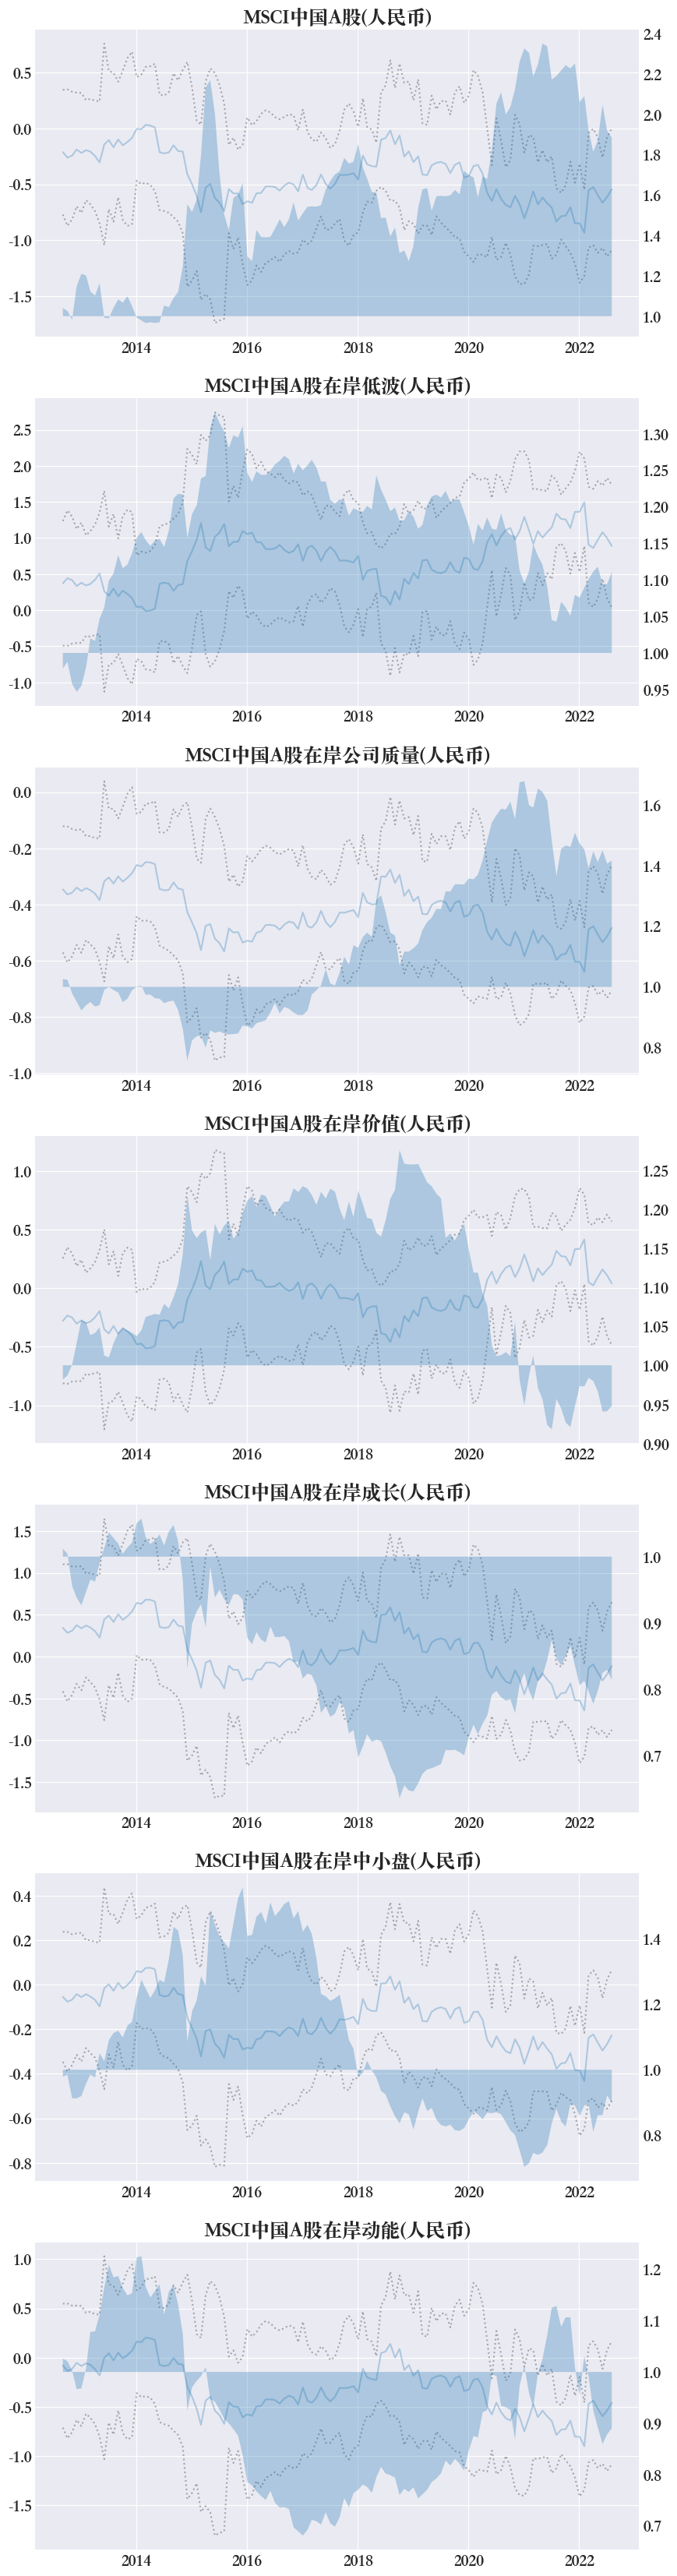

In [20]:
_xx= (date_model.to_timestamp()-date_model.to_timestamp()[0]).days/365
ig,ax =plt.subplots(fund_dim,1,figsize=(10,fund_dim*6))




data_fund=np.exp(Df_Factor.T.cumsum())
for i in range(fund_dim):


    TT_figure= _xx+T_begin
    SR_t_mean_fig_i=[]
    SR_t_mean_fig_i=[]
    for j in range(len(traces)):
        SR_t_mean_fig = SR_t_mode_pred[j]
    #ax[i].plot(TT_figure,SR_t_mean_fig[i]+1*SR_t_std_fig[i],':',color="k")

        SR_t_mean_fig_i.append(pd.Series(SR_t_mean_fig[i]))
    SR_t_mean_fig_i_df=pd.concat(SR_t_mean_fig_i,axis=1)
    model_average=SR_t_mean_fig_i_df.mean(axis=1)
    model_std=SR_t_mean_fig_i_df.std(axis=1)
    ax[i].plot(TT_figure,model_average-model_std,"k:",alpha=0.3)
    ax[i].plot(TT_figure,model_average+model_std,"k:",alpha=0.3)
    ax[i].plot(TT_figure,model_average,alpha=0.3)
    
    #ax[i].plot(TT_figure,SR_t_mean_fig[i]-1*SR_t_std_fig[i],':',color="k")
    ax[i].set_title(Df_Factor.index.values[i])
    ax[i].grid()


    ax_right = ax[i].twinx()

    #__drawdown =(draw_down_price[i] - draw_down_price[i+"_max"])/draw_down_price[i+"_max"]
    #print(__drawdown)
    ax_right.fill_between(TT_figure,data_fund[Df_Factor.index.values[i]],1,alpha=0.3)



array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

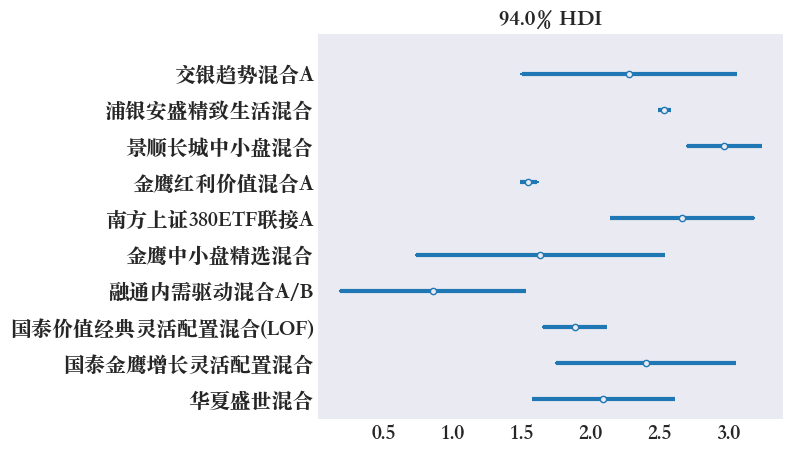

In [24]:
 az.plot_forest(
    trace_alpha_total_dy,
    var_names=["IC_alpha"],
    #kind="ridgeplot",
    combined=True,
    coords={"Alpha":__Df_alpha_model.index.values},
    labeller=az.labels.NoVarLabeller(),
)

In [16]:
model_BMA=[]
for i in Df_macro.index:
    print( "model_total_"+i)
    model_BMA.append("model_total_"+i)
for i in Df_macro.index:
    print( "trace_alpha_total_"+i)   


model_total_dp
model_total_dy
model_total_ep
model_total_de
model_total_svar
model_total_bm
model_total_ntis
model_total_tbl
model_total_ity
model_total_itr
model_total_tms
model_total_dfy
model_total_infl
trace_alpha_total_dp
trace_alpha_total_dy
trace_alpha_total_ep
trace_alpha_total_de
trace_alpha_total_svar
trace_alpha_total_bm
trace_alpha_total_ntis
trace_alpha_total_tbl
trace_alpha_total_ity
trace_alpha_total_itr
trace_alpha_total_tms
trace_alpha_total_dfy
trace_alpha_total_infl


# 模型结果存储

In [10]:
 
# for i in Df_macro.index:
#     files="trace_{}.nc".format(i)
#     s="""trace_alpha_total_{}.to_netcdf('{}')""".format(i,files)
#     exec(s)
    

    

#trace_alpha_total_dp.to_netcdf("trace_dp.nc")

# 模型结果读入

## trace 读入（netcdf）

In [17]:
import netCDF4 as nc

for i in Df_macro.index:
    files="trace_{}.nc".format(i)
    s="""trace_alpha_total_{}= az.from_netcdf('{}')""".format(i,files)
    exec(s)



## 模型读入

In [18]:

for i in Df_macro.index:
    model_name = "model_total_"+i
    result_name = "trace_alpha_total_"+i
    Df_model_example = Df_macro.loc[[i]]
    
    macro_dim =Df_model_example.shape[0]
    coords_test = {"Fund": Df_Factor.index.values, "date":data_total.columns.to_timestamp().astype("int"),"macro":Df_model_example.index.values,"Alpha":__Df_alpha_model.index.values}
    s="""with pm.Model(coords=coords_test) as {}:
        sharpe_ratio= pm.Normal("μ", prior_mu.T, prior_std, dims=("Fund"))
        sharpe_ratio=at.reshape(sharpe_ratio,(fund_dim,1))
        beta = pm.Normal("beta", mu=0, sigma=20,shape=(fund_dim,macro_dim),dims=("Fund","macro"))
        data_macro = pm.Data("data", Df_model_example.values.astype(float),mutable=True,dims=("macro","date"))
        sharpe_ratio_t = pm.Deterministic("SR_t",at.tile(sharpe_ratio,(1,model_dim_T)) + at.dot(beta,data_macro),dims=("Fund","date"))
        #sd_dist=pm.Exponential("std",1.0,shape=6,dims=("Fund"))
        sd_dist=pm.Exponential("std",1.0,shape=fund_dim,dims=("Fund"))
        sd_dist= at.reshape(sd_dist,(fund_dim,1))
        sd_T =at.tile(sd_dist,(1,model_dim_T)) 
        obs = pm.Normal("obs",mu=sharpe_ratio_t*sd_dist,sigma=sd_dist,observed=Df_Factor,dims=("Fund", "date"))


        ############################################
        ############################################
        ###############################################
        ############################################
        factor_loading = pm.Normal("factor_loading", mu=0, sigma=2,shape=fund_dim,dims=("Fund"))
        factor_loading= at.reshape(factor_loading,(fund_dim,1))


        factor_loading_T =at.tile(factor_loading,(1,T_len))                         
        factor_loading_T=factor_loading_T*sharpe_ratio_t                
        factor_loading_sum= factor_loading_T.sum(axis=0)
        factor_loading_sum =at.reshape(factor_loading_sum,(1,T_len)) 
        factor_loading_sum_stack=at.tile(factor_loading_sum,(alpha_len,1))  

        alpha = pm.Normal("μ_alpha",alpha_mean__prior, alpha_std__prior)
        alpha_n = pm.Normal("IC_alpha",alpha,sigma=1,shape=alpha_len,dims=("Alpha"))
        alpha_n= at.reshape(alpha_n,(alpha_len,1))


        IC_alpha_t = pm.Deterministic("SR_alpha_t",at.tile(alpha_n,(1,T_len)) + factor_loading_sum_stack,dims=("Alpha","date"))

        chol, corr, stds = pm.LKJCholeskyCov(
            "chol", n=alpha_len, eta=LKJ_eta__prior, sd_dist=pm.Exponential.dist(LKJ_st__prior), compute_corr=True
        )






        __stds =  at.reshape(stds,(alpha_len,1)) 
        __stds_t = at.tile(__stds,(1,T_len)) 

        T_n_cov =np.eye(T_len)

        obs_sharpe=pm.MatrixNormal('vals', mu=IC_alpha_t*__stds_t, rowchol=chol,colcov=T_n_cov)

        __Df_alpha_fit_data_model=__Df_alpha_model.values[~np.isnan(__Df_alpha_model.values)]
        alpha_fit_variable = obs_sharpe[~np.isnan(__Df_alpha_model.values)]
        obss=pm.Normal("_IC",alpha_fit_variable,sigma=0.00001,observed=__Df_alpha_fit_data_model)
    """.format(model_name)
    exec(s)

In [19]:
for i in Df_macro.index:
    model_name = "model_total_"+i
    result_name = "trace_alpha_total_"+i
    print(i)


dp
dy
ep
de
svar
bm
ntis
tbl
ity
itr
tms
dfy
infl


# 模型BMA平均

In [70]:
trace_BMA=[trace_alpha_total_dp,
trace_alpha_total_dy,
trace_alpha_total_ep,
trace_alpha_total_de,
trace_alpha_total_svar,
trace_alpha_total_bm,
trace_alpha_total_ntis,
trace_alpha_total_tbl,
trace_alpha_total_ity,
trace_alpha_total_itr,
trace_alpha_total_tms,
trace_alpha_total_dfy,
trace_alpha_total_infl]

In [21]:
trace_alpha_total_infl

Inference data with groups:
	> posterior
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [23]:
# trace_BMA_test=[trace_alpha_total_dp,
# trace_alpha_total_dy,
# trace_alpha_total_ep]
model_BMA=[]
for i in Df_macro.index:
    print( "model_total_"+i)
    model_BMA.append("model_total_"+i)

model_total_dp
model_total_dy
model_total_ep
model_total_de
model_total_svar
model_total_bm
model_total_ntis
model_total_tbl
model_total_ity
model_total_itr
model_total_tms
model_total_dfy
model_total_infl


In [22]:
model_dict = dict(zip(model_BMA, trace_BMA))
comp_ = az.compare(model_dict,ic="loo",method="BB-pseudo-BMA",b_samples=1000,seed=RANDOM_SEED, scale="log",var_name="obs")


In [25]:
comp_ = az.compare(model_dict,ic="loo",method="BB-pseudo-BMA",b_samples=1000,seed=RANDOM_SEED, scale="log",var_name="_IC")


/Users/xinyuexu/opt/anaconda3/envs/FOF/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/xinyuexu/opt/anaconda3/envs/FOF/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/xinyuexu/opt/anaconda3/en

In [26]:
#az.loo(trace_BMA[0],var_name="_IC")

In [24]:
import seaborn as sns
cm=sns.color_palette("Spectral", as_cmap=True)
comp_.style.background_gradient(cmap=cm)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_total_itr,0,-991.733799,271.383973,0.000000,0.920542,27.567331,0.000000,False,log
model_total_tms,1,-1032.543686,299.928270,40.809887,0.065184,26.563386,27.807477,False,log
model_total_dfy,2,-1056.059328,276.526546,64.325529,0.002322,30.597447,22.932378,False,log
model_total_tbl,3,-1057.525279,289.074867,65.791480,0.000072,26.067230,25.877978,False,log
model_total_de,4,-1066.491518,337.674742,74.757719,0.011880,22.159912,37.207267,False,log
model_total_bm,5,-1101.070365,331.886417,109.336566,0.000000,22.227429,25.489761,False,log
model_total_ity,6,-1113.149865,325.354705,121.416066,0.000000,41.964553,25.641349,False,log
model_total_ep,7,-1133.474380,351.614893,141.740581,0.000000,17.426921,28.610367,False,log
model_total_svar,8,-1140.321079,380.208376,148.587280,0.000000,33.512770,44.652188,False,log
model_total_infl,9,-1140.765941,333.547830,149.032142,0.000000,32.226146,30.510028,False,log


In [27]:

comp_

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_total_ntis,0,11276.123155,1020.463892,0.000000,0.236366,5.386038,0.000000,True,log
model_total_dy,1,11275.501293,1021.209559,0.621862,0.206982,5.831754,4.815956,True,log
model_total_tms,2,11273.827416,1022.942940,2.295738,0.118037,5.511045,5.582036,True,log
model_total_tbl,3,11273.231090,1023.910526,2.892065,0.203552,5.607932,7.737561,True,log
model_total_dfy,4,11272.318143,1024.482632,3.805012,0.079175,5.985008,5.910858,True,log
model_total_dp,5,11270.091743,1026.960280,6.031411,0.035521,5.531971,6.581153,True,log
model_total_ity,6,11269.801834,1027.164092,6.321321,0.015640,5.734494,5.785991,True,log
model_total_de,7,11269.790322,1027.039101,6.332833,0.026498,5.582711,5.831997,True,log
model_total_bm,8,11269.328264,1027.515486,6.794891,0.025946,5.182887,6.601697,True,log
model_total_itr,9,11269.166268,1028.103305,6.956886,0.020621,5.339563,6.255287,True,log


In [31]:
comp_.to_excel("BMA_1.xlsx")

In [36]:
weights = comp_.loc[model_BMA]["weight"]

In [28]:
#ppc_2 = pm.sample_posterior_predictive(trace=trace_alpha_total_ep, model=model_total_ep, progressbar=False)
# ppc_w = pm.sample_posterior_predictive_w(
#     traces=trace_BMA,
#     models=[model_total_dp, model_total_dy, model_total_ep],
#     weights=comp.weight.sort_index(ascending=True),
#     progressbar=True,
# )


In [89]:
#data_total.columns.to_timestamp().astype("int").astype('datetime64[ns]')

In [135]:
az.summary(trace_alpha_total_ntis, var_names=["beta"], round_to=2)
az.summary(trace_alpha_total_itr, var_names=["beta"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[MSCI中国A股(人民币), itr]",0.52,0.05,0.47,0.57,0.04,0.03,2.86,17.14,1.87
"beta[MSCI中国A股在岸低波(人民币), itr]",-0.81,0.14,-0.95,-0.67,0.10,0.08,2.30,11.56,2.87
"beta[MSCI中国A股在岸公司质量(人民币), itr]",0.21,0.07,0.14,0.28,0.05,0.04,2.56,11.24,2.29
"beta[MSCI中国A股在岸价值(人民币), itr]",-0.52,0.60,-1.13,0.08,0.43,0.36,2.84,26.84,1.91
"beta[MSCI中国A股在岸成长(人民币), itr]",0.74,0.44,0.30,1.18,0.31,0.26,2.54,10.87,2.24
"beta[MSCI中国A股在岸中小盘(人民币), itr]",0.29,0.14,0.15,0.43,0.10,0.08,2.58,12.60,2.18
"beta[MSCI中国A股在岸动能(人民币), itr]",0.60,0.68,-0.09,1.28,0.48,0.41,2.48,10.96,2.32


In [52]:
trace_alpha_total_dp

Inference data with groups:
	> posterior
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [1]:
# for i in Df_macro.index:
#     model_name = "model_total_"+i
#     result_name = "trace_alpha_total_"+i
   
#     sss="""with {}:
 
#     pm.sample_posterior_predictive({}, extend_inferencedata=True)
#     """.format(model_name,result_name)

#     RANDOM_SEED = 8924
    
#     exec(sss)
       

In [ ]:
for i in Df_macro.index:
    model_name = "model_total_"+i
    result_name = "trace_alpha_total_"+i
   
    sss="""with {}:
 
    pm.sample_posterior_predictive({}, extend_inferencedata=True)
    """.format(model_name,result_name)

    RANDOM_SEED = 8924
    
    exec(sss)

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [71]:
ppc_w = az.stats.weight_predictions(trace_BMA,weights=weights.values)

In [134]:
import xarray as xr
def weight_predictions_return(idatas, weights=None):
    """
    Generate weighted posterior predictive samples from a list of InferenceData
    and a set of weights.
    Parameters
    ---------
    idatas : list[InferenceData]
        List of :class:`arviz.InferenceData` objects containing the groups `posterior_predictive`
        and `observed_data`. Observations should be the same for all InferenceData objects.
    weights : array-like, optional
        Individual weights for each model. Weights should be positive. If they do not sum up to 1,
        they will be normalized. Default, same weight for each model.
        Weights can be computed using many different methods including those in
        :func:`arviz.compare`.
    Returns
    -------
    idata: InferenceData
        Output InferenceData object with the groups `posterior_predictive` and `observed_data`.
    See Also
    --------
    compare :  Compare models based on PSIS-LOO `loo` or WAIC `waic` cross-validation
    """
    if len(idatas) < 2:
        raise ValueError("You should provide a list with at least two InferenceData objects")

    if not all("predictions" in idata.groups() for idata in idatas):
        raise ValueError(
            "All the InferenceData objects must contain the `predictions` group"
        )

    if not all(idatas[0].observed_data.equals(idata.observed_data) for idata in idatas[1:]):
        raise ValueError("The observed data should be the same for all InferenceData objects")

    if weights is None:
        weights = np.ones(len(idatas)) / len(idatas)
    elif len(idatas) != len(weights):
        raise ValueError(
            "The number of weights should be the same as the number of InferenceData objects"
        )

    weights = np.array(weights, dtype=float)
    weights /= weights.sum()

    len_idatas = [
        idata.predictions.dims["chain"] * idata.predictions.dims["draw"]
        for idata in idatas
    ]

    if not all(len_idatas):
        raise ValueError("At least one of your idatas has 0 samples")

    new_samples = (np.min(len_idatas) * weights).astype(int)

    new_idatas = [
        az.extract(idata, group="posterior_predictive",var_names=["obs","_IC"], num_samples=samples).reset_coords()
        for samples, idata in zip(new_samples, idatas)
    ]

    
    weighted_samples = az.InferenceData(
        predictions=xr.concat(new_idatas, dim="sample"),
        observed_data=idatas[0].observed_data,
    )

    return weighted_samples

In [97]:
import xarray as xr
def weight_predictions_(idatas, weights=None):
    """
    Generate weighted posterior predictive samples from a list of InferenceData
    and a set of weights.
    Parameters
    ---------
    idatas : list[InferenceData]
        List of :class:`arviz.InferenceData` objects containing the groups `posterior_predictive`
        and `observed_data`. Observations should be the same for all InferenceData objects.
    weights : array-like, optional
        Individual weights for each model. Weights should be positive. If they do not sum up to 1,
        they will be normalized. Default, same weight for each model.
        Weights can be computed using many different methods including those in
        :func:`arviz.compare`.
    Returns
    -------
    idata: InferenceData
        Output InferenceData object with the groups `posterior_predictive` and `observed_data`.
    See Also
    --------
    compare :  Compare models based on PSIS-LOO `loo` or WAIC `waic` cross-validation
    """
    if len(idatas) < 2:
        raise ValueError("You should provide a list with at least two InferenceData objects")

    if not all("predictions" in idata.groups() for idata in idatas):
        raise ValueError(
            "All the InferenceData objects must contain the `predictions` group"
        )

    if not all(idatas[0].observed_data.equals(idata.observed_data) for idata in idatas[1:]):
        raise ValueError("The observed data should be the same for all InferenceData objects")

    if weights is None:
        weights = np.ones(len(idatas)) / len(idatas)
    elif len(idatas) != len(weights):
        raise ValueError(
            "The number of weights should be the same as the number of InferenceData objects"
        )

    weights = np.array(weights, dtype=float)
    weights /= weights.sum()

    len_idatas = [
        idata.predictions.dims["chain"] * idata.predictions.dims["draw"]
        for idata in idatas
    ]

    if not all(len_idatas):
        raise ValueError("At least one of your idatas has 0 samples")

    new_samples = (np.min(len_idatas) * weights).astype(int)

    new_idatas = [
        az.extract(idata, group="predictions", num_samples=samples).reset_coords()
        for samples, idata in zip(new_samples, idatas)
    ]

    weighted_samples = az.InferenceData(
        predictions=xr.concat(new_idatas, dim="sample"),
        observed_data=idatas[0].observed_data,
    )

    return weighted_samples

In [139]:
ppc_pred=weight_predictions_(trace_BMA,weights=weights.values)

In [143]:
ppc_pred_r=weight_predictions_return(trace_BMA,weights=weights.values)

In [147]:
ppc_pred_r.predictions.to_netcdf("post_r.ditr")

NotImplementedError: variable 'sample' is a MultiIndex, which cannot yet be serialized to netCDF files (https://github.com/pydata/xarray/issues/1077). Use reset_index() to convert MultiIndex levels into coordinate variables instead.

In [110]:
month_interval =(trace_alpha_total_infl.observed_data.date).astype('datetime64[ns]')[3]-(trace_alpha_total_infl.observed_data.date).astype('datetime64[ns]')[0]

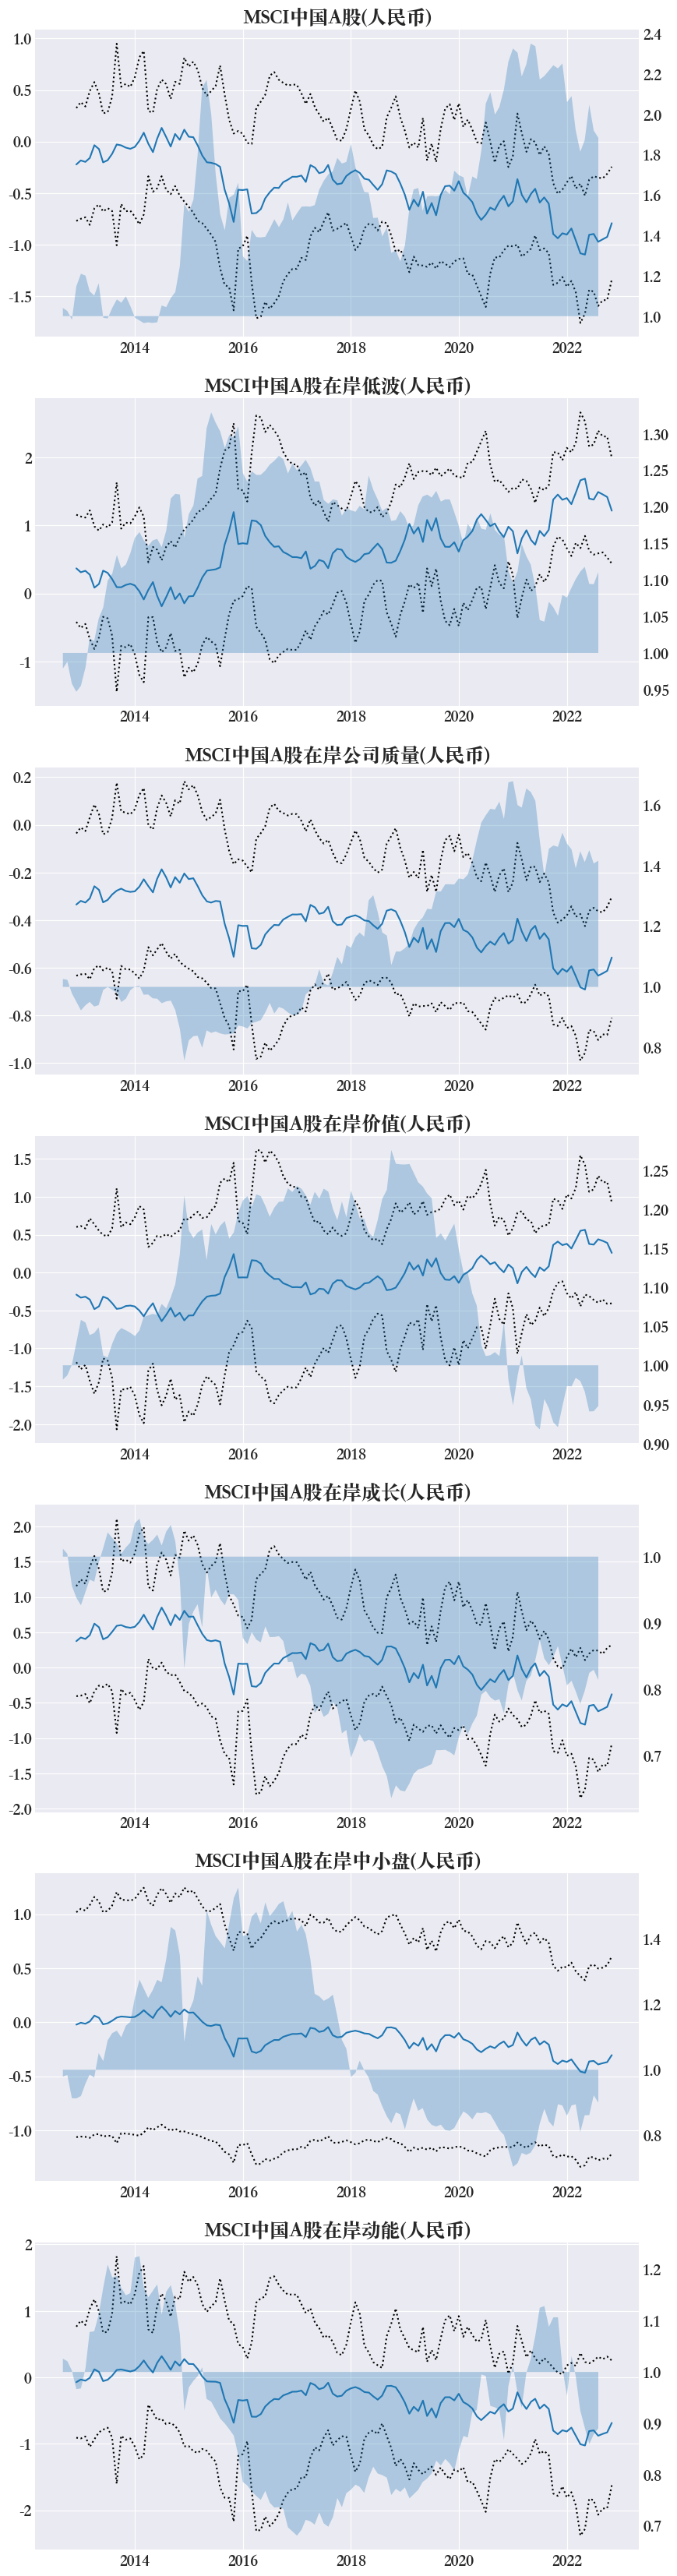

In [111]:



fig,ax =plt.subplots(fund_dim,1,figsize=(10,fund_dim*6))

SR_t_mean_fig=ppc_pred.predictions.stack()["SR_t"].mean(axis=2)
SR_t_std_fig=ppc_pred.predictions.stack()["SR_t"].std(axis=2)

TT_figure_predict=(ppc_pred.observed_data.date).astype('datetime64[ns]')+month_interval
TT_figure=(ppc_pred.observed_data.date).astype('datetime64[ns]')
data_fund=np.exp(Df_Factor.T.cumsum())
for i in range(fund_dim):
  
    
 
    
    
    ax[i].plot(TT_figure_predict,SR_t_mean_fig[i]+1*SR_t_std_fig[i],':',color="k")
    ax[i].plot(TT_figure_predict,SR_t_mean_fig[i])
    ax[i].plot(TT_figure_predict,SR_t_mean_fig[i]-1*SR_t_std_fig[i],':',color="k")
    ax[i].set_title(Df_Factor.index.values[i])
    ax[i].grid()
    
    
    ax_right = ax[i].twinx()
    
    #__drawdown =(draw_down_price[i] - draw_down_price[i+"_max"])/draw_down_price[i+"_max"]
    #print(__drawdown)
    ax_right.fill_between(TT_figure,data_fund[Df_Factor.index.values[i]],1,alpha=0.3)


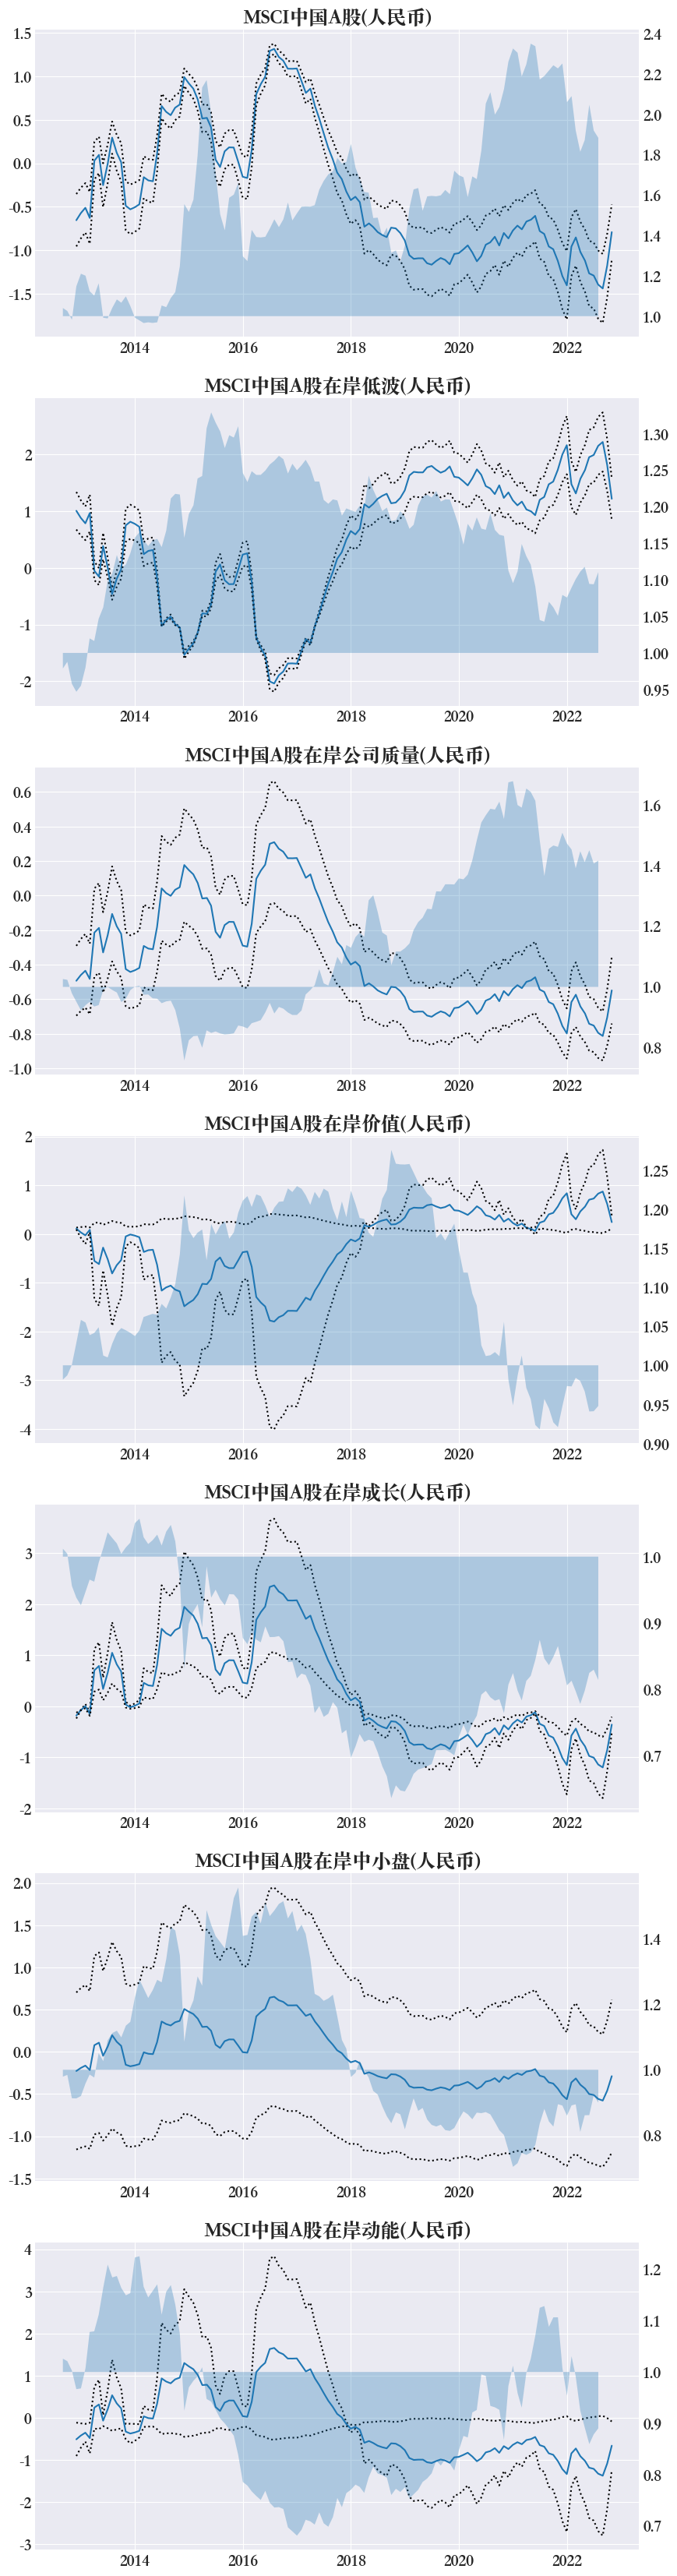

In [55]:
fig,ax =plt.subplots(fund_dim,1,figsize=(10,fund_dim*6))

SR_t_mean_fig=trace_alpha_total_ntis.predictions.stack(pooled_chain=("chain", "draw"))["SR_t"].mean(axis=2)
SR_t_std_fig=trace_alpha_total_ntis.predictions.stack(pooled_chain=("chain", "draw"))["SR_t"].std(axis=2)

TT_figure_predict=(trace_alpha_total_ntis.observed_data.date).astype('datetime64[ns]')+month_interval
TT_figure=(trace_alpha_total_ntis.observed_data.date).astype('datetime64[ns]')
data_fund=np.exp(Df_Factor.T.cumsum())
for i in range(fund_dim):
  
    
 
    
    
    ax[i].plot(TT_figure_predict,SR_t_mean_fig[i]+1*SR_t_std_fig[i],':',color="k")
    ax[i].plot(TT_figure_predict,SR_t_mean_fig[i])
    ax[i].plot(TT_figure_predict,SR_t_mean_fig[i]-1*SR_t_std_fig[i],':',color="k")
    ax[i].set_title(Df_Factor.index.values[i])
    ax[i].grid()
    
    
    ax_right = ax[i].twinx()
    
    #__drawdown =(draw_down_price[i] - draw_down_price[i+"_max"])/draw_down_price[i+"_max"]
    #print(__drawdown)
    ax_right.fill_between(TT_figure,data_fund[Df_Factor.index.values[i]],1,alpha=0.3)

    #ax[i].legend()

<function pymc.sampling.forward.sample_posterior_predictive_w(traces, samples: Optional[int] = None, models: Optional[List[pymc.model.Model]] = None, weights: Union[numpy.ndarray, List[float], NoneType] = None, random_seed: Union[int, Sequence[int], numpy.ndarray, NoneType, numpy.random.mtrand.RandomState, numpy.random._generator.Generator] = None, progressbar: bool = True, return_inferencedata: bool = True, idata_kwargs: dict = None)>

In [ ]:
#Df_macro_example_predict=Df_macro_predict.loc[["infl"]]

In [ ]:
# with model_total_dp:
    
#     # update values of predictors:
#     pm.set_data({"data": Df_macro_example_predict.values.astype(float)})
# # use the updated values and predict outcomes and probabilities:
#     trace_alpha_total_dp = pm.sample_posterior_predictive(
#         trace_alpha_total_dp,
#     var_names=["SR_t"],
#     return_inferencedata=True,
#     predictions=True,
#     extend_inferencedata=True,
#     random_seed=RANDOM_SEED,
# )
    
    
    






       

In [ ]:

    
#     s ="""with {}:
#         pm.set_data({"data": Df_macro_example_predict.values.astype(float)})
#         # use the updated values and predict outcomes and probabilities:
#         {} = pm.sample_posterior_predictive(
#             {},
#         var_names=["SR_t"],
#         return_inferencedata=True,
#         predictions=True,
#         extend_inferencedata=True,
#         random_seed=RANDOM_SEED,
#         )""".format(model_name,result_name,result_name)
#     exec(s)
    

In [128]:
x = az.extract(ppc_w, group="posterior_predictive", var_names=["obs","_IC"]).reset_coords()

ValueError: conflicting dimensions for multi-index product variables 'chain' ('sample',), 'draw' ('sample',)

In [ ]:
# For loop over dates 
start_value   = 1000
account_value = start_value
floor         = 0.8
floor_value   = floor * account_value

# recall that a drop > 1/m% would break the floor  
m = 3

import numpy as np
for step in range( len(risky_rets.index) ):
    # computing the cushion (as a percentage of the current account value)
    cushion = (account_value - floor_value) / account_value
    
    # compute the weight for the allocation on the risky asset
    risky_w = m * cushion
    #print(risky_w)
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)

    # the last two conditions ensure that the risky weight is in [0,1]
    
    # compute the weight for the allocation on the safe asset
    safe_w  = 1 - risky_w
    
    # compute the value allocation
    risky_allocation = risky_w * account_value
    safe_allocation  = safe_w  * account_value
    
    # compute the new account value: this is given by the new values from both the risky and the safe assets
    account_value = risky_allocation * (1 + risky_rets.iloc[step] ) + safe_allocation  * (1 + safe_rets.iloc[step]  )

    # save data: current account value, cushions, weights
    account_history.iloc[step] = account_value
    cushion_history.iloc[step] = cushion 
    risky_w_history.iloc[step] = risky_w

# given the CPPI wealth saved in the account_history, we can get back the CPPI returns
cppi_rets = ( account_history / account_history.shift(1) - 1 ).dropna()

In [ ]:
def weight_ew(r, cap_ws=None, max_cw_mult=None, microcap_thr=None, **kwargs):
    """
    Returns the weights of the Equally-Weighted (EW) portfolio based on the asset returns "r" as a DataFrame. 
    If the set of cap_ws is given, the modified scheme is computed, i.e., 
    microcaps are removed and a capweight tether applied.
    """
    ew = pd.Series(1/len(r.columns), index=r.columns)
    if cap_ws is not None:
        cw = cap_ws.loc[r.index[0]] # starting cap weight
        if microcap_thr is not None and microcap_thr > 0.0:
            # exclude microcaps according to the threshold    
            ew[ cw < microcap_thr ] = 0
            ew = ew / ew.sum()
        if max_cw_mult is not None and max_cw_mult > 0:
            # limit weight up to a multiple of capweight
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew / ew.sum()
    return ew
def weight_rp(r, cov_estimator=sample_cov, **kwargs):
    '''
    Produces the weights of the risk parity portfolio given a covariance matrix of the returns.
    The default coavariance estimator is the sample covariance matrix.
    '''
    est_cov = cov_estimator(r, **kwargs)
    return risk_parity_weigths(est_cov)  

def backtest_weight_scheme(r, window=36, weight_scheme=weight_ew, **kwargs):
    '''
    Backtests a given weighting scheme. Here:
    - r: asset returns to use to build the portfolio
    - window: the rolling window used
    - weight_scheme: the weighting scheme to use, it must the name of a 
    method that takes "r", and a variable number of keyword-value arguments
    '''
    n_periods = r.shape[0]
    windows = [ (start, start+window) for start in range(0,n_periods-window) ]
    weights = [ weight_scheme( r.iloc[win[0]:win[1]], **kwargs) for win in windows ]
    weights = pd.DataFrame(weights, index=r.iloc[window:].index, columns=r.columns)    
    returns = (weights * r).sum(axis=1,  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

